In [1]:
#=
using Pkg; 
packages = ["Knet", "AutoGrad", "Random", "Test", "MLDatasets", "CUDA", "Plots", "GR","Statistics",
            "IterTools", "StatsBase", "DSP", "Images", "DelimitedFiles", "MultivariateStats", "PyPlot", "PyCall"];
Pkg.add(packages);
=#

In [1]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA


## Handwritten modules
using .TUM69: load_accel_data   # Data reading
using .Preprocess: process_accel_signal # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [2]:
AutoGrad.set_gc_function(AutoGrad.default_gc)

default_gc (generic function with 1 method)

In [3]:
# Trick from Deniz Hoca to deal with this issue: https://github.com/denizyuret/Knet.jl/issues/524
#=
using Knet
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end
=#

In [4]:
# Array type setting for GPU usage
a_type() = (CUDA.functional() ? KnetArray{Float32} : Array{Float32})

a_type (generic function with 1 method)

In [5]:
# CUDA information
GC.gc(true)
CUDA.device()

LoadError: CUDA.jl did not successfully initialize, and is not usable.
If you did not see any other error message, try again in a new session
with the JULIA_DEBUG environment variable set to 'CUDA'.

In [6]:
path = CUDA.functional() ? "/userfiles/vaydingul20/data/trial" : "./../data/trial" # path of the main data
DATA_PATH = isdir(path) && path

"./../data/trial"

In [7]:
X_train, y_train,
X_test, y_test, 
material_dict = @time load_accel_data(DATA_PATH; mode = "baseline");  # Data loading routine

Train accel data is being loaded!
Test accel data is being loaded!
  2.690428 seconds (4.89 M allocations: 166.862 MiB, 1.91% gc time)


In [8]:
println("X_train = ", summary(X_train))
println("y_train = ", summary(y_train))
println("X_test  = ", summary(X_test))
println("y_test  = ", summary(y_test))
println("material_dict = ", summary(material_dict))

X_train = 3-element Array{Array{Float32,1},1}
y_train = 3-element Array{Int8,1}
X_test  = 3-element Array{Array{Float32,1},1}
y_test  = 3-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [9]:
#Preprocessing on the acceleration data
@time X_train_modified, y_train_modified = process_accel_signal(X_train, y_train);
@time X_test_modified, y_test_modified = process_accel_signal(X_test, y_test);

  7.228821 seconds (6.87 M allocations: 364.125 MiB, 6.75% gc time)
  0.139623 seconds (388 allocations: 30.432 MiB)


In [10]:
println("X_train = ", summary(X_train_modified))
println("y_train = ", summary(y_train_modified))
println("X_test  = ", summary(X_test_modified))
println("y_test  = ", summary(y_test_modified))
println("material_dict = ", summary(material_dict))

X_train = 50×300×1×24 Array{Float32,4}
y_train = 24-element Array{Int8,1}
X_test  = 50×300×1×24 Array{Float32,4}
y_test  = 24-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [30]:
material_dict

Dict{String,Int8} with 3 entries:
  "G1IsolatingFoilMesh"   => 1
  "G1EpoxyRasterPlate"    => 0
  "G1PlasticMeshVersion1" => 2

In [21]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 10
INPUT_SIZE = size(X_test_modified)[1:3]
OUTPUT_SIZE = size(collect(keys(material_dict)))[1];

In [22]:
# Minibatching
dtrn = minibatch(X_train_modified, y_train_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true)
dtst = minibatch(X_test_modified, y_test_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true);

In [23]:
#=
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(25, 150, 1 , relu, 0.0, (1, 1), (1, 1), (2, 2), false)]; 
    hidden=[10], optimizer_type = sgd, lr = 0.15, loss_fnc=nll, accuracy_fnc = accuracy, atype=a_type())
=#

In [26]:
#=
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), true),
        (3, 3, 100, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 150, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 200, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (4, 12,400, relu, 0.5, (1, 0), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE , relu, 0.5, (0, 0), (1, 1), (1, 1), false)
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype=a_type())

=#
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), false)
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype=a_type())


GCN((Main.Network.Conv(P(Array{Float32,4}(3,3,1,50)), P(Array{Float32,4}(1,1,50,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, Array{Float32,N} where N),), Knet.Train20.adam, 0.0001, Main.Network.nll4, Main.Network.accuracy4, 0.0, 0.0005)

┣████████████████████┫ [100.00%, 2000/2000, 25:52/25:52, 1.29i/s] 


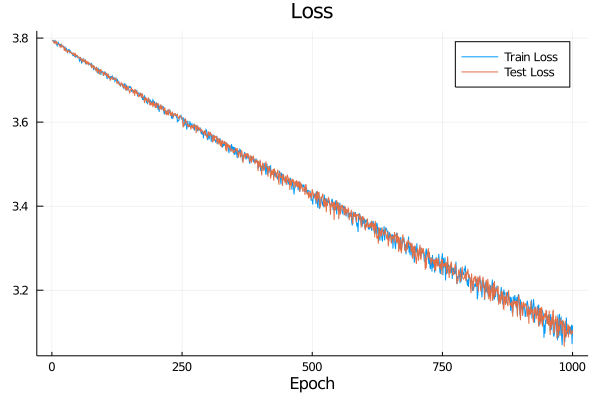

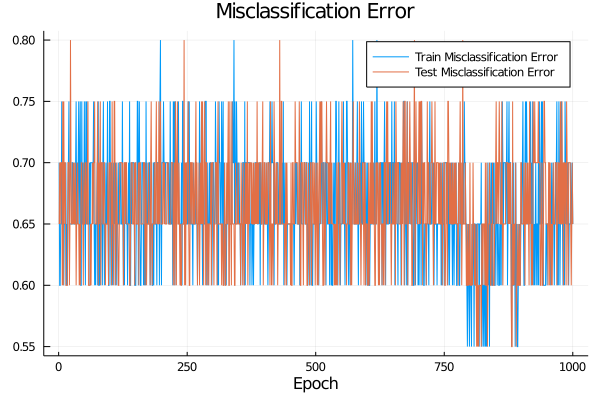

TRAINING PARAMETERS


Activation Function = relu
Optimizer Type = adam
Learning Rate = 0.0001
LAYERS:


Main.Network.Conv ==> W = (3, 3, 1, 50)   b = (1, 1, 50, 1)
In this network configuration,
there are total 500 parameters.
Final Loss
Train Loss = 3.1160326
Test Loss = 3.0971813


Final Misclassification Error
Train Misclassification Error = 0.65
Test Misclassification Error = 0.65


Test Accuracy = 0.3


4×1000 Array{Float32,2}:
 3.79379  3.79352  3.79393  3.79116  …  3.10244  3.11767  3.07169  3.11603
 3.79528  3.79444  3.79082  3.78841     3.09683  3.09541  3.10581  3.09718
 0.7      0.6      0.6      0.65        0.65     0.65     0.7      0.65
 0.65     0.7      0.65     0.7         0.6      0.65     0.7      0.65

In [31]:
# Training routine
# Currently, the model is not working due to the issue mentioned in: https://github.com/denizyuret/Knet.jl/issues/624#
# As soon as it is solved, I hope the model will be accurately working.
res = train_summarize!(model, dtrn, dtst; 
                       train_type = "epoch", progress_bar = true ,fig = true, info = true, 
                       epoch = 1000, conv_epoch = 50, max_conv_cycle = 20)

In [18]:
notify("OK!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

{}

100     5  100     2  100     3      1      1  0:00:03  0:00:02  0:00:01     2


Process(`curl https://notify.run/fnx04zT7QmOlLLa6 -d OK!`, ProcessExited(0))